* Updated to GDS 2.0 version
* Link to original blog post: https://towardsdatascience.com/twitchverse-a-network-analysis-of-twitch-universe-using-neo4j-graph-data-science-d7218b4453ff

In [ ]:
%matplotlib inline
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

sns.set(font_scale = 1.5)

In [ ]:
# Connect to Neo4j
driver = GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'letmein'))

def read_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

# Exploratory graph analysis
Before digging into graph algorithms, I like first to get acquainted with the graph at hand.
We will perform an exploratory graph analysis by executing a couple of Cypher queries to learn more about the network. All bar charts in this blog post are created with the help of the Seaborn library. I have prepared a Jupyter notebook that contains all the code to help you follow this blog post. To begin, we will retrieve the top ten streamers by all-time historical view count.

[Text(0, 0, 'fextralife'),
 Text(1, 0, 'riotgames'),
 Text(2, 0, 'esl_csgo'),
 Text(3, 0, 'shroud'),
 Text(4, 0, 'beyondthesummit'),
 Text(5, 0, 'summit1g'),
 Text(6, 0, 'lirik'),
 Text(7, 0, 'sodapoppin'),
 Text(8, 0, 'xqcow'),
 Text(9, 0, 'imaqtpie')]

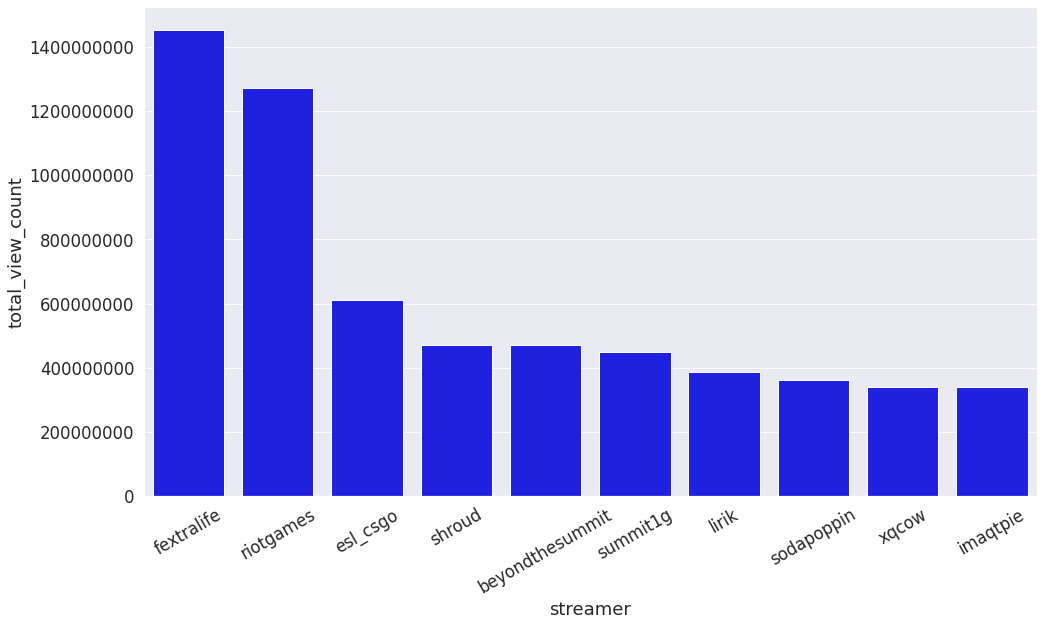

In [ ]:
data = read_query("""
MATCH (u:Stream)
WHERE exists(u.total_view_count)
RETURN u.name as streamer,
       u.total_view_count as total_view_count
ORDER BY total_view_count DESC 
LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="streamer", y="total_view_count", data=data, color="blue")
ax.ticklabel_format(style='plain', axis='y')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

Before I get attacked by Twitch domain experts, I would like to point out that we are only analyzing Twitch streamers who have live-streamed between the 7th and the 10th of May. There might be other streamers that have higher all-time view counts. The top three all-time view count streamers in our graph seem to be a team of streamers and not an individual. I am not familiar with the mentioned streams. I only know that esl_csgo streams Counter-Strike: Global Offensive pretty much 24/7. Next, we will investigate the top ten streamers with the highest follower count.

[Text(0, 0, 'tfue'),
 Text(1, 0, 'shroud'),
 Text(2, 0, 'rubius'),
 Text(3, 0, 'auronplay'),
 Text(4, 0, 'pokimane'),
 Text(5, 0, 'thegrefg'),
 Text(6, 0, 'myth'),
 Text(7, 0, 'ibai'),
 Text(8, 0, 'summit1g'),
 Text(9, 0, 'nickmercs')]

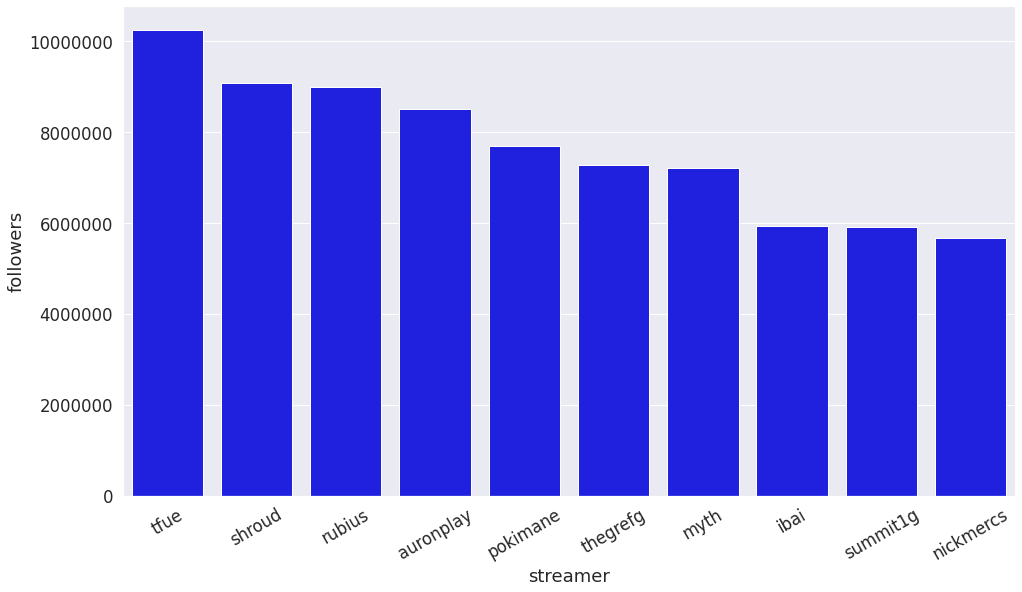

In [ ]:
data = read_query("""
MATCH (u:Stream)
WHERE u.followers IS NOT NULL
RETURN u.name as streamer,
       u.followers as followers
ORDER BY followers DESC 
LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="streamer", y="followers", data=data, color="blue")
ax.ticklabel_format(style='plain', axis='y')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

Interestingly, we get a completely different group of streamers than in the previous query. Except for Shroud, he is fourth in the all-time view count category and second in the highest follower count. Each follower receives a notification when a stream goes live. It is almost unimaginable to think that 9 million people receive a notification when Rubius goes live or almost 8 million people when Pokimane starts streaming. I am curious to learn how long the streams have existed. We will aggregate the count of streams by their user creation date.

[Text(0, 0, '2007'),
 Text(1, 0, '2008'),
 Text(2, 0, '2009'),
 Text(3, 0, '2010'),
 Text(4, 0, '2011'),
 Text(5, 0, '2012'),
 Text(6, 0, '2013'),
 Text(7, 0, '2014'),
 Text(8, 0, '2015'),
 Text(9, 0, '2016'),
 Text(10, 0, '2017'),
 Text(11, 0, '2018'),
 Text(12, 0, '2019'),
 Text(13, 0, '2020'),
 Text(14, 0, '2021')]

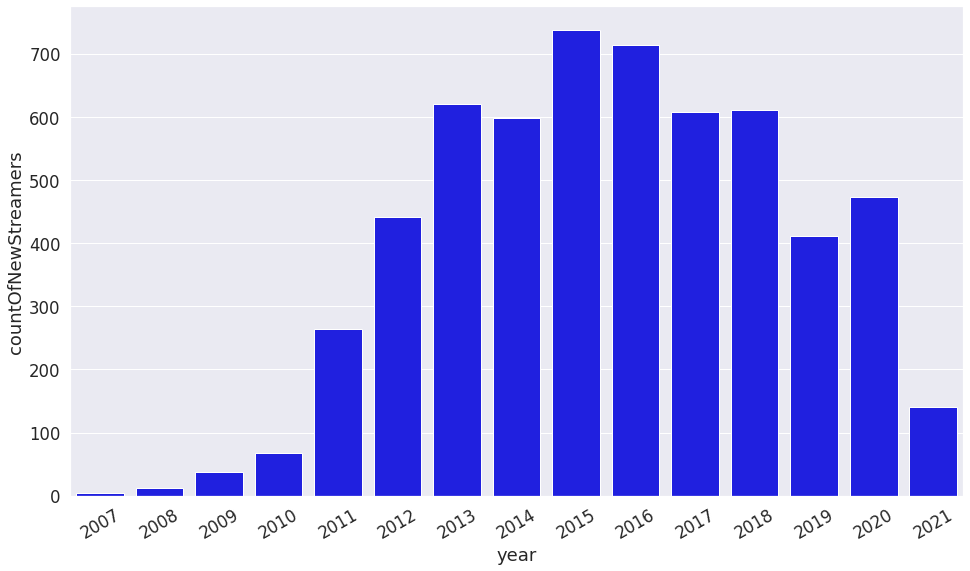

In [ ]:
data = read_query("""
MATCH (u:Stream)
WHERE u.createdAt IS NOT NULL
RETURN u.createdAt.year as year, 
      count(*) as countOfNewStreamers
ORDER BY year;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="year", y="countOfNewStreamers", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

Here I need to add another disclaimer. We are aggregating by the date of when the user account was created and not when they first started streaming. Unfortunately, we don't have the date of the first stream. Judging by the results, at least some of the streamers have already a ten-year career on Twitch. Another quite shocking fact, at least to me. We can move away from the streamers and investigate which games are played by most streamers. Note that a streamer can play more than a single game, so they might be counted under multiple games. Our data was collected between Friday and Sunday, so a streamer might prefer to play Valorant on Friday and Poker on Sunday.

[Text(0, 0, 'Just Chatting'),
 Text(1, 0, 'Resident Evil Village'),
 Text(2, 0, 'Grand Theft Auto V'),
 Text(3, 0, 'League of Legends'),
 Text(4, 0, 'Fortnite'),
 Text(5, 0, 'VALORANT'),
 Text(6, 0, 'Call of Duty: Warzone'),
 Text(7, 0, 'Apex Legends'),
 Text(8, 0, 'Counter-Strike: Global Offensive'),
 Text(9, 0, 'Minecraft')]

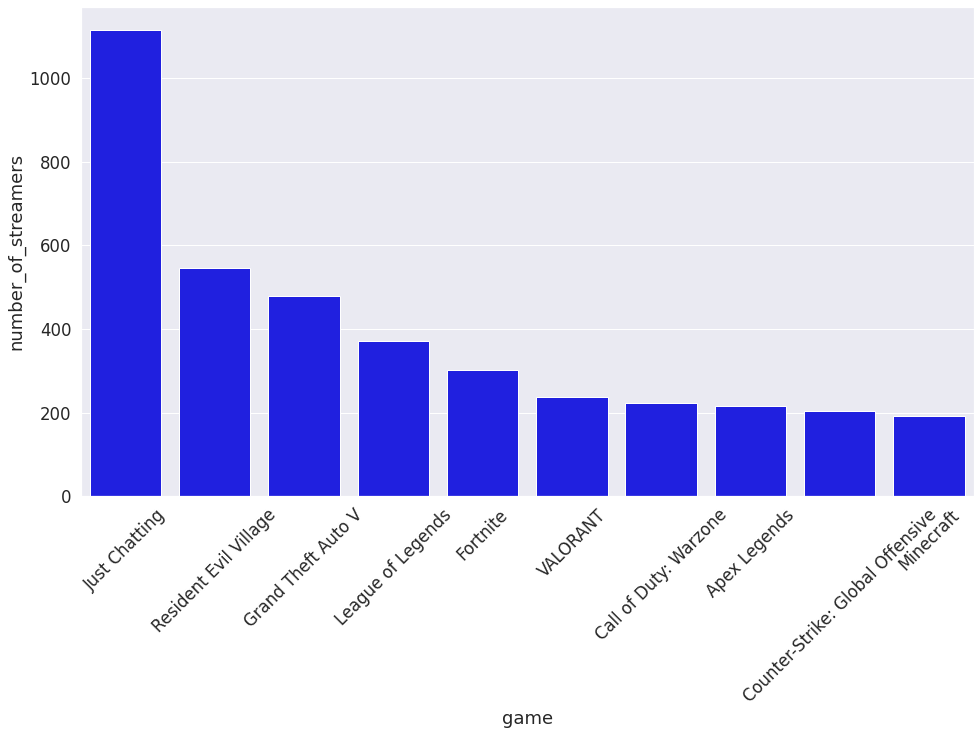

In [ ]:
data = read_query("""
MATCH (g:Game)
RETURN g.name as game,
       count{ (g)<--() } as number_of_streamers
ORDER BY number_of_streamers DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="game", y="number_of_streamers", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

By far, the most popular is the Just Chatting category. The cause of the Just Chatting category popularity might be due to the reason that it is used for all streams that don't play a specific video game. This might include anything from cooking shows to "In real life" streams, where the streamer is walking around the world with a camera in hand. Otherwise, it seems that Resident Evil Village, GTA V, and League of Legends are the most popular games by streamers.
Most of the streamers belong to a team or two. We can investigate which teams have the highest member count along with all the games that the team members broadcast.

In [ ]:
read_query("""
MATCH (t:Team)
WITH t, count{ (t)<--() } as count_of_members
ORDER BY count_of_members DESC LIMIT 10
MATCH (t)<-[:HAS_TEAM]-(member)-[:PLAYS]->(game)
RETURN t.name as team,
       count_of_members,
       collect(distinct member.name) as members, 
       collect(distinct game.name) as games
""")

,team,count_of_members,members,games
0,G FUEL: The Official Energy Drink of Esports®,64,"[suto, parasite, trihex, draynilla, sirlarr, a...","[Just Chatting, Call of Duty: Black Ops Cold W..."
1,PUBG Partners,46,"[taezzang, codemarco, mumino, katcontii, smoro...","[Just Chatting, PLAYERUNKNOWN'S BATTLEGROUNDS,..."
2,Corsair,43,"[backyardis, varsitygaming, esl_pwnz, lokenpla...","[Sea of Thieves, Resident Evil Village, Hood: ..."
3,Twitch Ambassadors,36,"[unrooolie, legiqn, mery_soldier, trihex, litt...","[Call of Duty: Warzone, Resident Evil Village,..."
4,TSM,36,"[kitingishard, spicalol, tweekssb, savix, tann...","[Teamfight Tactics, League of Legends, Super S..."
5,inSight,36,"[salista_belladonna, derhauge, daannyy, rickym...","[New Pokémon Snap, Just Chatting, It Takes Two..."
6,Team Liquid,30,"[smexycake, hungrybox, scoped, stewie2k, fr0ze...","[Tom Clancy's Rainbow Six Siege, Super Smash B..."
7,Method,30,"[ds_lily, purespam, coxie, therealesquire, ski...","[Path of Exile, Old School RuneScape, World of..."
8,Blue Microphones Crew,27,"[kobe0802, legiqn, silentsentry, falloutplays,...","[Call of Duty: Black Ops Cold War, Resident Ev..."
9,Fade2Karma,26,"[jane, roffle, duellinksmeta, nicholena, filth...","[Teamfight Tactics, Hearthstone, Yu-Gi-Oh! Due..."


G Fuel team had 64 members stream on the weekend between the 7th and 10th of May 2021. Its members cover 34 different game categories on Twitch. Before we dive into network analysis, let's examine the users that are VIPs of the most streams.

[Text(0, 0, 'nightbot'),
 Text(1, 0, 'karuzo1g'),
 Text(2, 0, 'kristoferyee'),
 Text(3, 0, 'crazyslick'),
 Text(4, 0, 'wolfabelle'),
 Text(5, 0, 'streamelements'),
 Text(6, 0, 'supibot'),
 Text(7, 0, 'kephlivestream'),
 Text(8, 0, 'letshugotv'),
 Text(9, 0, 'saiiren')]

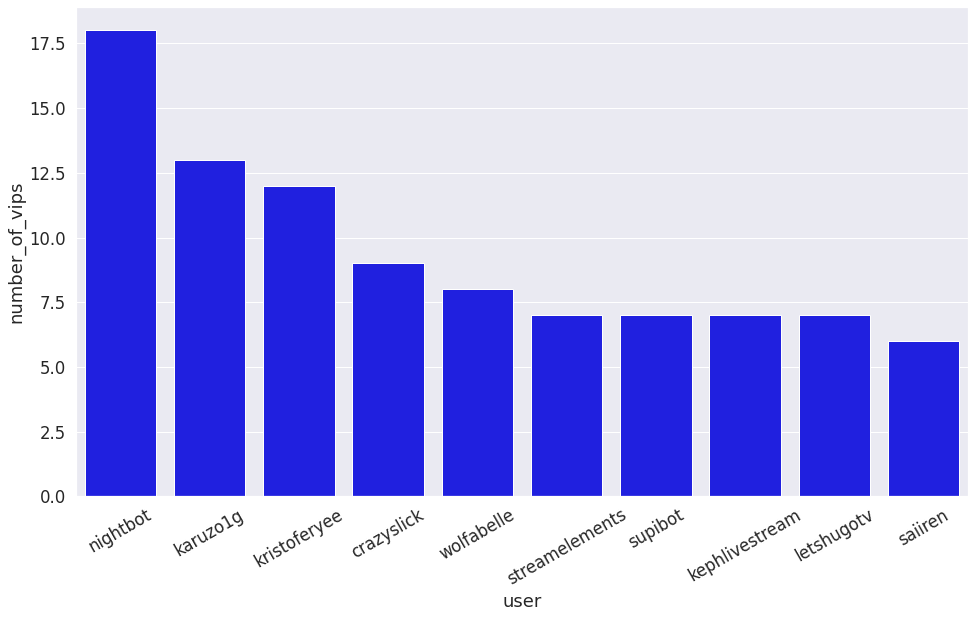

In [ ]:
data = read_query("""
MATCH (u:User)
RETURN u.name as user, count{ (u)-[:VIP]->() } as number_of_vips
ORDER BY number_of_vips DESC LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="user", y="number_of_vips", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

I would venture that Nightbot and Supibot are both bots. Having bots as VIPs seems a bit weird. I always thought that bots were moderators of the chat with the ability to remove messages with links and such. We can also examine which users are moderating for the highest count of streams.

[Text(0, 0, 'nightbot'),
 Text(1, 0, 'streamelements'),
 Text(2, 0, 'moobot'),
 Text(3, 0, 'streamlabs'),
 Text(4, 0, 'ssakdook'),
 Text(5, 0, 'wizebot'),
 Text(6, 0, 'fossabot'),
 Text(7, 0, '9kmmrbot'),
 Text(8, 0, 'priestbot'),
 Text(9, 0, 'soundalerts')]

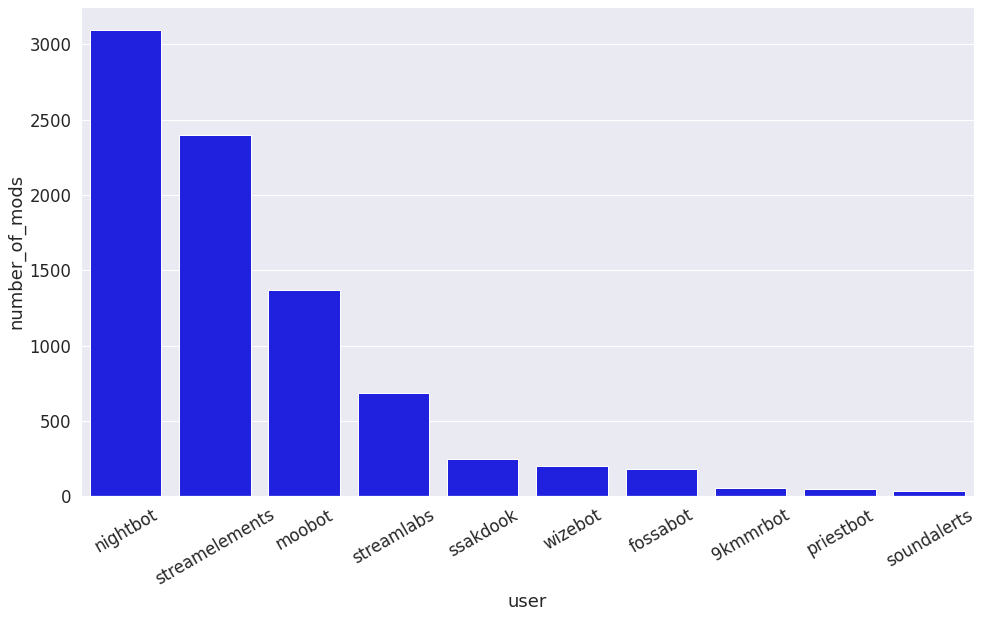

In [ ]:
data = read_query("""
MATCH (u:User)
RETURN u.name as user, count{ (u)-[:MODERATOR]->() } as number_of_mods
ORDER BY number_of_mods DESC LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="user", y="number_of_mods", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

As expected, all top ten users with the highest count of moderator roles are most likely bots, with Nightbot being the most popular.
# User network analysis
You might remember that only around 6000 out of 10 million users in our graph are streamers. If we put that into perspective, only 0.06% of users are streamers. The other users in our database are users who have chatted on other streamers' broadcasts. So far, we have entirely ignored them in our exploratory graph analysis. That is, until now. Graph data science focuses on analyzing connections between entities in a network.
The time is right to put on our graph data science hats and examine relationships between users in the network. As a brief reminder of the graph structure, let's visualize a small subgraph of the user network.

In [ ]:
read_query("""
MATCH (s:Stream)
WITH s LIMIT 1
CALL {
    WITH s
    MATCH p=(s)--(:Stream)
    RETURN p
    LIMIT 5

    UNION

    WITH s
    MATCH p=(s)--(:User)
    RETURN p
    LIMIT 5
}

RETURN p
""")

,p
0,(())
1,(())
2,(())
3,(())
4,(())
5,(())
6,(())
7,(())
8,(())
9,(())


As mentioned in the previous blog post, streamers behave like regular users. They can moderate other broadcasts, can engage in their chat, or earn VIP status. This was the reason that drove the graph model decision to represent streamers as regular users with a secondary label Stream. We don't want to have two nodes in the graph represent a single real-world entity.
To start, we will evaluate the node degree distribution. Node degree is simply the count of relationships each node has. Here, we are dealing with a directed network as the relationship direction holds semantic value. If Aimful is a moderator of the Itsbigchase stream, it doesn't automatically mean that then Itsbigchase is a moderator of the Aimful stream. When dealing with directed networks, you can split the node degree distribution into in-degree, where you count incoming relationships, and out-degree, where you are counting outgoing connections. First, we will examine the out-degree distribution.

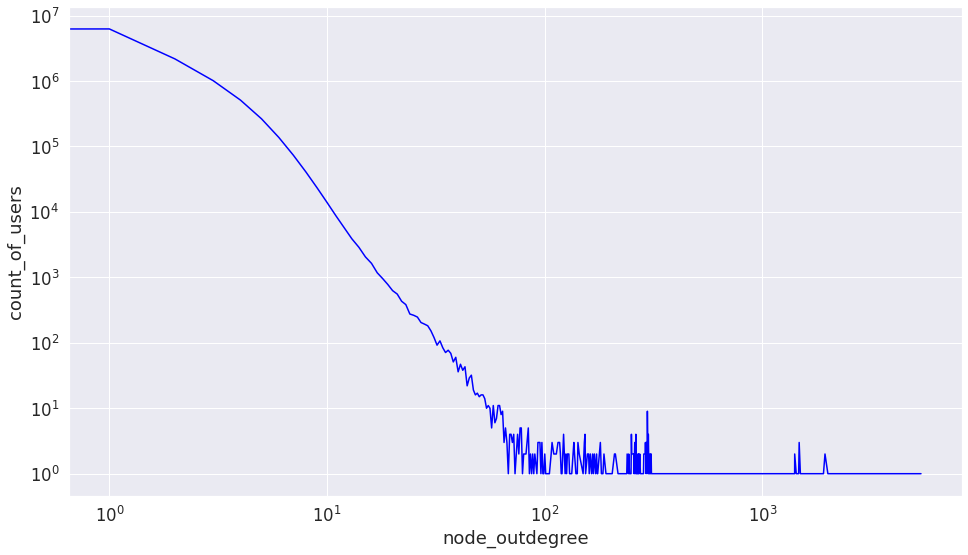

In [ ]:
data = read_query("""MATCH (u:User)
WITH u, count{ (u)-[:CHATTER|VIP|MODERATOR]->() } as node_outdegree
RETURN node_outdegree, count(*) as count_of_users
ORDER BY node_outdegree ASC""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.lineplot(x="node_outdegree", y="count_of_users", data=data, color="blue")
ax.set_yscale("log")
ax.set_xscale("log")

A log-log plot visualizes the out-degree distribution. Both axes have a logarithmic scale. Around six million out of a total of ten million users have exactly a single outgoing relationship, meaning they have only chatted in a single stream. The vast majority of users have less than ten outgoing connections. A couple of users have more than 100 outgoing links, but I would venture a guess that they are most likely bots. Some mathematicians might consider the out-degree following a Power-Law distribution. Now, let's look at the in-degree distribution. We already know that only streamers will have an in-degree higher than 0. Only the users who broadcast their streams can have users engage in their chat. Consequently, around 99.999% of users have an in-degree value of 0. You could almost treat this network as a bipartite graph, except that there are also relationships between streamers. We will visualize the in-degree distribution only for streamers.

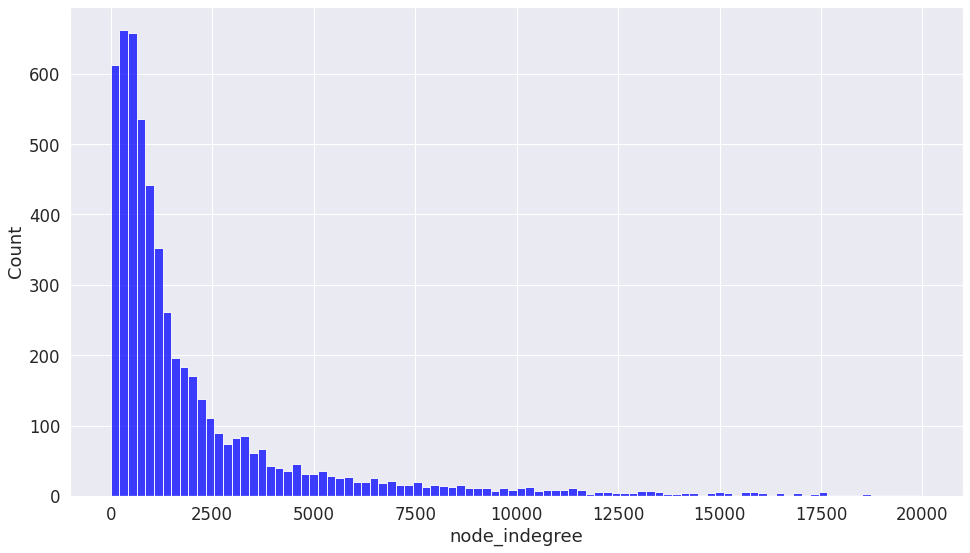

In [ ]:
data = read_query("""MATCH (u:Stream)
RETURN u, count{ (u)<-[:CHATTER|VIP|MODERATOR]-() } as node_indegree
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.histplot(x="node_indegree",data=data, color="blue", binrange=[0,20000])



It is pretty interesting to observe that the in-degree distribution also follows the Power-law distribution. Most streamers have less than 1000 active chatters on the weekend, while some streamers have more than 15000 active chatters.

# Graph Data Science library

The GDS library executes graph algorithms on a specialized in-memory graph format to improve the performance and scale of graph algorithms. Using native or cypher projections, we can project the stored graph in our database to the in-memory graph format. Before we can execute any graph algorithms, we have to project a view of our stored graph to in-memory graph format. We can filter which parts of the graph we want to project. There is no need to add nodes and relationships that will not be used as an input to a graph algorithm. We will begin by projecting all User and Stream nodes and the possible relationships between them, which are CHATTER, MODERATOR, and VIP.


In [ ]:
data = read_query("""
CALL gds.graph.project('twitch', ['User', 'Stream'], ['CHATTER', 'VIP', 'MODERATOR'])
""")

## Weakly Connected Components
The Weakly connected components algorithm (WCC) is used to find disparate islands or components of nodes within a given network. A node can reach all the other nodes in the same component when you disregard the relationship direction. 
Use the following Cypher query to execute a Weakly-Connected Components algorithm on the Twitch network we have previously projected in memory. The stats method of the algorithm is used when we are interested in only high-level statistics of algorithm results.

In [ ]:
read_query("""
CALL gds.wcc.stats('twitch')
YIELD componentCount, componentDistribution
""")

,componentCount,componentDistribution
0,1,"{'p99': 10514239, 'min': 10514176, 'max': 1051..."


Very interesting to see that the user network is composed of only a single connected component. For example, you could find an undirected path between a user who watches Japanese streams and another user who looks at Hungarian streams. It might be interesting to remove the bots from the graph and rerun the WCC algorithm. I have a hunch that the Nightbot and other bots help connect disparate parts of the network into a single connected component.
With the current in-memory graph projection, we can also filter at algorithm execution time nodes or relationships. In the next example, I have chosen to consider only Stream nodes and connections between them.

In [ ]:
read_query("""
CALL gds.wcc.stats('twitch', {nodeLabels:['Stream']})
YIELD componentCount, componentDistribution
""")

,componentCount,componentDistribution
0,1902,"{'p99': 3, 'min': 1, 'max': 3692, 'mean': 3.04..."


With this variation of the WCC algorithm, we are effectively looking at chat communication between streamers. Only Stream nodes are considered, and so, only relationships between Stream nodes are used as an input to the WCC algorithm. There are a total of 1902 separate components in the streamer network. The largest component contains around 65% of all stream nodes. And then, we are dealing with primarily single node components, where a streamer hasn't chatted in other streamers' broadcast on the specific weekend the data was scraped.
## PageRank
PageRank is probably one of the most famous graph algorithms. It is used to calculate node importance by considering the inbound relationships of a node as well as the importance of the nodes linking to it. PageRank was initially used to calculate the importance of websites by Google, but it can be used in many different scenarios.
Use the following Cypher query to execute the PageRank algorithm on the whole user network.

[Text(0, 0, 'yassuo'),
 Text(1, 0, 'trainwreckstv'),
 Text(2, 0, 'loltyler1'),
 Text(3, 0, 'riotgames'),
 Text(4, 0, 'xqcow'),
 Text(5, 0, 'csgomc_ru'),
 Text(6, 0, 'benjyfishy'),
 Text(7, 0, 'alexby11'),
 Text(8, 0, 'nickmercs'),
 Text(9, 0, 'esl_csgo')]

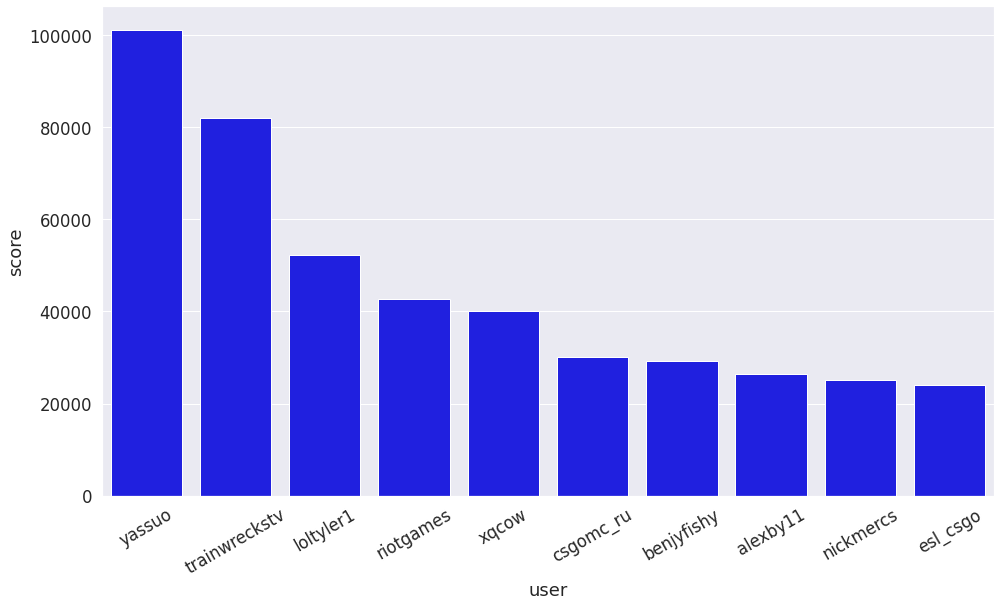

In [ ]:
data = read_query("""
CALL gds.pageRank.stream('twitch')
YIELD nodeId, score
WITH nodeId, score
ORDER BY score
DESC LIMIT 10
RETURN gds.util.asNode(nodeId).name as user, score
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="user", y="score", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

Results might vary significantly if you have scraped the Twitch API at some other times. In this analysis, chat engagement only between the 7th and the 10th of May is considered. My assumption is that streamers with the highest PageRank score are likely to have the highest count of other streamers engaging in their chat. We can easily validate this assumption by running the PageRank algorithm on the streamer subset of the network.

In [ ]:
read_query("""CALL gds.pageRank.stream('twitch', {nodeLabels:['Stream']})
YIELD nodeId, score
WITH nodeId, score
ORDER BY score
DESC LIMIT 5
MATCH (n)-[:PLAYS]->(g:Game)
WHERE id(n)=nodeId
RETURN n.name as user, score, 
      collect(g.name) as games,
      count{ (n)<--(:Stream) } as stream_relationships_count, 
      count{ (n)<--(:User) } as user_relationship_count""")

,user,score,games,stream_relationships_count,user_relationship_count
0,yassuo,38.614368,"[Slots, League of Legends]",16,22632
1,trainwreckstv,32.479834,[Slots],101,83934
2,loltyler1,19.037138,[League of Legends],9,44564
3,xqcow,12.269107,"[Just Chatting, Grand Theft Auto V]",105,280443
4,riotgames,12.202457,[League of Legends],128,316735


The top ten streamers by PageRank score are almost identical when we consider all the users or when we consider only the streamers of the Twitch network. What I found surprising is that Yassuo is in first place with only 16 inbound relationships from other streamers and 22000 relationships from regular users. I would venture a guess that the streamers who chatted in Yassuo's broadcast are themselves important by the PageRank score.

In [ ]:
read_query("""
MATCH (s:Stream{name:"yassuo"})<--(o:Stream)
RETURN collect(o.name) as other_streamers
""")

,other_streamers
0,"[m0e_tv, benjyfishy, sanchovies, macaiyla, oda..."


It seems that my assumption has some merit to it. Among the streamers who chatted in Yassuo's stream are loltyler1, trainwreckstv, benjyfishy. These streamers are also in the top 10 ratings by PageRank. It's not all about the number of relationships, the quality also does matter.
## Community detection
The last category of graph algorithms we will look at is the community detection category. Community detection or clustering algorithms are used to infer the community structure of a given network. Communities are vaguely defined as groups of nodes within a network that are more densely connected to one another than to other nodes. We could try to examine the community structure of the whole user network, but that does not make a pretty network visualization of results. First of all, we will release the existing project network from memory.

In [ ]:
read_query("""
CALL gds.graph.drop("twitch")
""")

,graphName,database,memoryUsage,sizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,density,creationTime,modificationTime,schema
0,twitch,neo4j,,-1,"{'Stream': {'properties': {}, 'label': 'Stream...","{'CHATTER': {'orientation': 'NATURAL', 'aggreg...",None,None,10514229,19723263,1.784120e-07,2021-05-21T17:13:58.338399000+02:00,2021-05-21T17:14:07.083342000+02:00,"{'relationships': {'CHATTER': {}, 'VIP': {}, '..."


I like to sometimes watch either chess or poker streamers. Let's analyze the community structure of a subgraph that contains poker and chess streamers. To ease our further queries, we will first tag relevant nodes with an additional node label.

In [ ]:
read_query("""
MATCH (s:Stream)-[:PLAYS]->(g:Game)
WHERE g.name in ["Chess", "Poker"]
SET s:PokerChess
""")

""


There were a total of 63 streamers that broadcasted either chess or poker on their channel.
If you only plan to run a single graph algorithm, you can use the anonymous graph feature, where you project and execute a graph algorithm in one step. Here, we will use the Louvain Modularity algorithm to infer the community structure of this subgraph. We will also treat this network as undirected. I would say that if a streamer engages in another streamer's chat, they are probably friends, and usually, friendship relationships go both ways. This time we will store the results of the Louvain Modularity algorithm back to the stored graph, so we can use the community structure information in our visualizations.

In [ ]:
read_query("""
CALL gds.graph.project('chesspoker', 'PokerChess', {ALL: {orientation:'UNDIRECTED', type:'*'}})
""")

In [ ]:
read_query("""CALL gds.louvain.write('chesspoker', {
    writeProperty:'louvain_chesspoker'
})""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,1288,63,0.6056,"[0.5552, 0.6055999999999999]",2,42,"{'p99': 8, 'min': 1, 'max': 8, 'mean': 1.5, 'p...",42,886,430,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


And now, I want to show you one last cool thing you can do in Neo4j. Instead of looking at which streamers interact with each other, we can examine which streamers share their audience. We don't have all the viewers in our database, but we have the viewers that have chatted on streamers' broadcasts. First, we will tag users who have more than a single outgoing relationship. This will help us speed up the audience comparison process.

In [ ]:
read_query("""CALL apoc.periodic.iterate("
    MATCH (u:User)
    WHERE count{ (u)-->(:Stream) } > 1
    RETURN u",
    "SET u:Audiences",
    {batchSize:50000, parallel:true}
)""")

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,86,4276825,41,4276825,0,0,0,{},"{'total': 86, 'committed': 86, 'failed': 0, 'e...","{'total': 4276825, 'committed': 4276825, 'fail...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 0, 'relatio..."


We need to infer a new network that depicts which streamers share their audience before we can run a community detection algorithm. To start off, we must project an in-memory graph.

In [ ]:
read_query("""
CALL gds.graph.project('shared-audience', 
  ['PokerChess', 'Audience'],
  {CHATTERS: {type:'*', orientation:'REVERSE'}})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,"{'Audience': {'properties': {}, 'label': 'Audi...","{'CHATTERS': {'orientation': 'REVERSE', 'aggre...",shared-audience,63,25,1030


Next, we will use the Node Similarity algorithm to infer the shared audience network. The Node Similarity algorithm uses the Jaccard similarity coefficient to compare how similar a pair of nodes are. We will assume that if two streamers share at least 5% of the audience. The mutate mode of the algorithms stores the results back to the in-memory projected graph. This was we can use the results of one algorithm as an input to another graph algorithm.

In [ ]:
read_query("""
CALL gds.nodeSimilarity.mutate('shared-audience',
 {similarityCutoff:0.05, topK:15, mutateProperty:'score', mutateRelationshipType:'SHARED_AUDIENCE', similarityMetric: 'Jaccard'})
""")

,createMillis,computeMillis,mutateMillis,postProcessingMillis,nodesCompared,relationshipsWritten,similarityDistribution,configuration
0,0,18,11,-1,20,68,"{'p1': 0.25, 'max': 1.0000057220458984, 'p5': ...","{'topK': 15, 'bottomK': 10, 'bottomN': 0, 'rel..."


And finally, we can run the community detection algorithm Louvain on the shared audience network between poker and chess streamers.

In [ ]:
read_query("""
CALL gds.louvain.write('shared-audience', 
       { nodeLabels:['PokerChess'],
         relationshipTypes:['SHARED_AUDIENCE'], 
         relationshipWeightProperty:'score',
         writeProperty:'louvain_shared_audience'})
""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,1036,63,0.422727,[0.4227270527894711],1,52,"{'p99': 4, 'min': 1, 'max': 5, 'mean': 1.21153...",10,3,95,"{'maxIterations': 10, 'writeConcurrency': 4, '..."
